In [1]:
import sys
import time
import random
from os.path import exists
from typing import *

# Common data science imports
import numpy as np
import pandas as pd
import torch
from torch.utils.data import random_split, DataLoader, Dataset
from sklearn.cluster import KMeans

# Visualization tools
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
from seaborn import heatmap
from tqdm import tqdm, notebook as tqdm_notebook

# GPyTorch and linear_operator imports
import gpytorch
from gpytorch.kernels import ScaleKernel, RBFKernel
from gpytorch.constraints import *
import linear_operator
from linear_operator.settings import max_cholesky_size
from linear_operator.operators.dense_linear_operator import DenseLinearOperator
from linear_operator.utils.cholesky import psd_safe_cholesky

# Custom soft GP and MLL imports
from gp.soft_gp.soft_gp import SoftGP
from gp.soft_gp.mll import HutchinsonPseudoLoss
from linear_solver.cg import linear_cg

# Data analysis and UCI dataset

# Utility functions for dataset handling
from gp.util import flatten_dataset, split_dataset, filter_param

# Experiment tracking
import wandb

# System path adjustments
sys.path.append("../")

In [2]:
# class SoftGP_baseline(torch.nn.Module):
#     def __init__(
#         self,
#         kernel: Callable,
#         inducing_points: torch.Tensor,
#         noise=1e-3,
#         learn_noise=False,
#         use_scale=False,
#         device="cpu",
#         dtype=torch.float32,
#         solver="solve",
#         max_cg_iter=50,
#         cg_tolerance=0.5,
#         mll_approx="hutchinson",
#         fit_chunk_size=1024,
#         use_qr=False,
#     ) -> None:
#         # Argument checking 
#         methods = ["solve", "cholesky", "cg"]
#         if not solver in methods:
#             raise ValueError(f"Method {solver} should be in {methods} ...")
        
#         # Check devices
#         devices = ["cpu"]
#         if torch.cuda.is_available():
#             devices += ["cuda"]
#             for i in range(torch.cuda.device_count()):
#                 devices += [f"cuda:{i}"]
#         if not device in devices:
#             raise ValueError(f"Device {device} should be in {devices} ...")

#         # Create torch module
#         super(SoftGP_baseline, self).__init__()

#         # Misc
#         self.device = device
#         self.dtype = dtype
        
#         # Mll approximation settings
#         self.solve_method = solver
#         self.mll_approx = mll_approx
#         self.hutch_normalization="randn"
#         # Fit settings
#         self.use_qr = use_qr
#         self.fit_chunk_size = fit_chunk_size

#         # Noise
#         self.noise_constraint = gpytorch.constraints.Positive()
#         noise = torch.tensor([noise], dtype=self.dtype, device=self.device)
#         noise = self.noise_constraint.inverse_transform(noise)
#         if learn_noise:
#             self.register_parameter("raw_noise", torch.nn.Parameter(noise))
#         else:
#             self.raw_noise = noise

#         # Kernel
#         self.use_scale = use_scale
#         if use_scale:
#             self.kernel = ScaleKernel(kernel).to(self.device)
#         else:
#             self.kernel = kernel.to(self.device)

#         # Inducing points
#         self.register_parameter("inducing_points", torch.nn.Parameter(inducing_points))

#         # Interpolation
#         def softmax_interp(X: torch.Tensor, sigma_values: torch.Tensor) -> torch.Tensor:
#             distances = torch.linalg.vector_norm(X - sigma_values, ord=2, dim=-1)
#             softmax_distances = torch.softmax(-distances, dim=-1)
#             return softmax_distances
#         self.interp = softmax_interp
        
#         # Fit artifacts
#         self.alpha = None
#         self.K_zz_alpha = None

#         # CG solver params
#         self.max_cg_iter = max_cg_iter
#         self.cg_tol = cg_tolerance
#         self.x0 = None
        
#     # -----------------------------------------------------
#     # Soft GP Helpers
#     # -----------------------------------------------------
    
#     @property
#     def noise(self):
#         return self.noise_constraint.transform(self.raw_noise)

#     def get_lengthscale(self) -> float:
#         if self.use_scale:
#             return self.kernel.base_kernel.lengthscale.cpu()
#         else:
#             return self.kernel.lengthscale.cpu()
        
#     def get_outputscale(self) -> float:
#         if self.use_scale:
#             return self.kernel.outputscale.cpu()
#         else:
#             return 1.

#     def _mk_cov(self, z: torch.Tensor) -> torch.Tensor:
#         return self.kernel(z, z).evaluate()
    
#     def _interp(self, x: torch.Tensor) -> torch.Tensor:
#         x_expanded = x.unsqueeze(1).expand(-1, self.inducing_points.shape[0], -1)
#         W_xz = self.interp(x_expanded, self.inducing_points)
#         return W_xz

#     # -----------------------------------------------------
#     # Linear solver
#     # -----------------------------------------------------

#     def _solve_system(
#         self,
#         kxx: linear_operator.operators.LinearOperator,
#         full_rhs: torch.Tensor,
#         x0: torch.Tensor = None,
#         forwards_matmul: Callable = None,
#         precond: torch.Tensor = None,
#         return_pinv: bool = False,
#     ) -> torch.Tensor:
#         use_pinv = False
#         with torch.no_grad():
#             try:
#                 if self.solve_method == "solve":
#                     solve = torch.linalg.solve(kxx, full_rhs)
#                 elif self.solve_method == "cholesky":
#                     L = torch.linalg.cholesky(kxx)
#                     solve = torch.cholesky_solve(full_rhs, L)
#                 elif self.solve_method == "cg":



#                     # # Perform pivoted Cholesky on the matrix K
#                     # k = 10  # Number of steps for the decomposition
#                     # L_k = pivoted_cholesky(kxx, max_iter=k)
#                     # def preconditioner(v):
#                     #     # Woodbury-based preconditioner P^{-1}v
#                     #     P_inv_v = (v / self.noise) - torch.matmul(
#                     #         L_k,
#                     #         torch.linalg.solve(
#                     #             torch.eye(L_k.size(1)) + (1 / self.noise) * torch.matmul(L_k.T, L_k),
#                     #             torch.matmul(L_k.T, v)
#                     #         )
#                     #     )
#                     #     return P_inv_v
                    
#                     #         # Source: https://github.com/AndPotap/halfpres_gps/blob/main/mlls/mixedpresmll.py
#                     # solve = linear_cg(
#                     #     forwards_matmul,
#                     #     full_rhs,
#                     #     max_iter=self.max_cg_iter,
#                     #     tolerance=self.cg_tol,
#                     #     initial_guess=x0,
#                     #     preconditioner=preconditioner,
#                     # )

#                     # Source: https://github.com/AndPotap/halfpres_gps/blob/main/mlls/mixedpresmll.py
#                     solve = linear_cg(
#                         forwards_matmul,
#                         full_rhs,
#                         max_iter=self.max_cg_iter,
#                         tolerance=self.cg_tol,
#                         initial_guess=x0,
#                         preconditioner=precond,
#                     )
#                 else:
#                     raise ValueError(f"Unknown method: {self.solve_method}")
#             except RuntimeError as e:
#                 print("Fallback to pseudoinverse: ", str(e))
#                 solve = torch.linalg.pinv(kxx.evaluate()) @ full_rhs
#                 use_pinv = True

#         # Apply torch.nan_to_num to handle NaNs from percision limits 
#         solve = torch.nan_to_num(solve)
#         return (solve, use_pinv) if return_pinv else solve

#     # -----------------------------------------------------
#     # Marginal Log Likelihood
#     # -----------------------------------------------------

#     def mll(self, X: torch.Tensor, y: torch.Tensor) -> torch.Tensor:
#         """Compute the marginal log likelihood of a soft GP:
            
#             log p(y) = log N(y | mu_x, Q_xx)

#             where
#                 mu_X: mean of soft GP
#                 Q_XX = W_xz K_zz W_zx

#         Args:
#             X (torch.Tensor): B x D tensor of inputs where each row is a point.
#             y (torch.Tensor): B tensor of targets.

#         Returns:
#             torch.Tensor:  log p(y)
#         """        
#         # Construct covariance matrix components
#         K_zz = self._mk_cov(self.inducing_points)
#         W_xz = self._interp(X)
        
#         if self.mll_approx == "exact":
#             # [Note]: Compute MLL with a multivariate normal. Unstable for float.
#             # 1. mean: 0
#             mean = torch.zeros(len(X), dtype=self.dtype, device=self.device)
            
#             # 2. covariance: Q_xx = (W_xz L) (L^T W_xz) + noise I  where K_zz = L L^T
#             L = psd_safe_cholesky(K_zz)
#             LK = (W_xz @ L).to(device=self.device)
#             cov_diag = self.noise * torch.ones(len(X), dtype=self.dtype, device=self.device)

#             # 3. N(mu, Q_xx)
#             normal_dist = torch.distributions.lowrank_multivariate_normal.LowRankMultivariateNormal(mean, LK, cov_diag, validate_args=None)
            
#             # 4. log N(y | mu, Q_xx)
#             return normal_dist.log_prob(y)
#         elif self.mll_approx == "hutchinson":
#             # [Note]: Compute MLL with Hutchinson's trace estimator
#             # 1. mean: 0
#             mean = torch.zeros(len(X), dtype=self.dtype, device=self.device)
            
#             # 2. covariance: Q_xx = W_xz K_zz K_zx + noise I
#             cov_mat = W_xz @ K_zz @ W_xz.T 
#             cov_mat += torch.eye(cov_mat.shape[1], dtype=self.dtype, device=self.device) * self.noise

#             # 3. log N(y | mu, Q_xx) \appox 
#             hutchinson_mll = HutchinsonPseudoLoss(self, num_trace_samples=10,vector_format=self.hutch_normalization)
#             return hutchinson_mll(mean, cov_mat, y)
#         else:
#             raise ValueError(f"Unknown MLL approximation method: {self.mll_approx}")
        
#     # -----------------------------------------------------
#     # Fit
#     # -----------------------------------------------------

#     def _direct_solve_fit(self, M, N, X, y, K_zz):
#         # Construct A and b for linear solve
#         #   A = (K_zz + hat{K}_zx @ noise^{-1} @ hat{K}_xz)
#         #   b = (hat{K}_zx @ noise^{-1}) y
#         if X.shape[0] * X.shape[1] <= 32768:
#             # Case: "small" X
#             # Form estimate \hat{K}_xz ~= W_xz K_zz
#             W_xz = self._interp(X)
#             hat_K_xz = W_xz @ K_zz
#             hat_K_zx = hat_K_xz.T
            
#             # Form A and b
#             Lambda_inv_diag = (1 / self.noise) * torch.ones(N, dtype=self.dtype).to(self.device)
#             A = K_zz + hat_K_zx @ (Lambda_inv_diag.unsqueeze(1) * hat_K_xz)
#             b = hat_K_zx @ (Lambda_inv_diag * y)
#         else:
#             # Case: "large" X
#             with torch.no_grad():
#                 # Initialize outputs
#                 A = torch.zeros(M, M, dtype=self.dtype, device=self.device)
#                 b = torch.zeros(M, dtype=self.dtype, device=self.device)
                
#                 # Initialize temporary values
#                 fit_chunk_size = self.fit_chunk_size
#                 batches = int(np.floor(N / fit_chunk_size))
#                 Lambda_inv = (1 / self.noise) * torch.eye(fit_chunk_size, dtype=self.dtype, device=self.device)
#                 tmp1 = torch.zeros(fit_chunk_size, M, dtype=self.dtype, device=self.device)
#                 tmp2 = torch.zeros(M, M, dtype=self.dtype, device=self.device)
#                 tmp3 = torch.zeros(fit_chunk_size, dtype=self.dtype, device=self.device)
#                 tmp4 = torch.zeros(M, dtype=self.dtype, device=self.device)
#                 tmp5 = torch.zeros(M, dtype=self.dtype, device=self.device)
                
#                 # Compute batches
#                 for i in range(batches):
#                     # Update A: A += W_zx @ Lambda_inv @ W_xz
#                     X_batch = X[i*fit_chunk_size:(i+1)*fit_chunk_size]
#                     W_xz = self._interp(X_batch)
#                     W_zx = W_xz.T
#                     torch.matmul(Lambda_inv, W_xz, out=tmp1)
#                     torch.matmul(W_zx, tmp1, out=tmp2)
#                     A.add_(tmp2)
                    
#                     # Update b: b += K_zz @ W_zx @ (Lambda_inv @ Y[i*batch_size:(i+1)*batch_size])
#                     torch.matmul(Lambda_inv, y[i*fit_chunk_size:(i+1)*fit_chunk_size], out=tmp3)
#                     torch.matmul(W_zx, tmp3, out=tmp4)
#                     torch.matmul(K_zz, tmp4, out=tmp5)
#                     b.add_(tmp5)
                
#                 # Compute last batch
#                 if N - (i+1)*fit_chunk_size > 0:
#                     Lambda_inv = (1 / self.noise) * torch.eye(N - (i+1)*fit_chunk_size, dtype=self.dtype, device=self.device)
#                     X_batch = X[(i+1)*fit_chunk_size:]
#                     W_xz = self._interp(X_batch)
#                     A += W_xz.T @ Lambda_inv @ W_xz
#                     b += K_zz @ W_xz.T @ Lambda_inv @ y[(i+1)*fit_chunk_size:]

#                 # Aggregate result
#                 A = K_zz + K_zz @ A @ K_zz

#         # Safe solve A \alpha = b
#         A = DenseLinearOperator(A)
#         self.alpha, use_pinv = self._solve_system(
#             A,
#             b.unsqueeze(1),
#             x0=torch.zeros_like(b),
#             forwards_matmul=A.matmul,
#             precond=None,
#             return_pinv=True
#         )

#         # Store for fast prediction
#         self.K_zz_alpha = K_zz @ self.alpha
#         return use_pinv

#     def _qr_solve_fit(self, M, N, X, y, K_zz):
#         if X.shape[0] * X.shape[1] <= 32768:
#             # Compute: W_xz K_zz
#             print("USING QR SMALL")
#             W_xz = self._interp(X)
#             hat_K_xz = W_xz @ K_zz
#         else:
#             # Compute: W_xz K_zz in a batched fashion
#             print("USING QR BATCH")
#             with torch.no_grad():
#                 # Compute batches
#                 fit_chunk_size = self.fit_chunk_size
#                 batches = int(np.floor(N / fit_chunk_size))
#                 Lambda_half_inv_diag = (1 / torch.sqrt(self.noise)) * torch.ones(fit_chunk_size, dtype=self.dtype, device=self.device)
#                 hat_K_xz = torch.zeros((N, M), dtype=self.dtype, device=self.device)
#                 for i in range(batches):
#                     start = i*fit_chunk_size
#                     end = (i+1)*fit_chunk_size
#                     X_batch = X[start:end,:]
#                     W_xz = self._interp(X_batch)
#                     torch.matmul(W_xz, K_zz, out=hat_K_xz[start:end,:])
                
#                 start = (i+1)*fit_chunk_size
#                 if N - start > 0:
#                     Lambda_half_inv_diag = (1 / torch.sqrt(self.noise)) * torch.eye(N - (i+1)*fit_chunk_size, dtype=self.dtype, device=self.device)
#                     X_batch = X[start:]
#                     W_xz = self._interp(X_batch)
#                     torch.matmul(W_xz, K_zz, out=hat_K_xz[start:,:])
        
#         # B^T = [(Lambda^{-1/2} \hat{K}_xz) U_zz ]
#         U_zz = psd_safe_cholesky(K_zz, upper=True, max_tries=10)
#         Lambda_half_inv_diag = (1 / torch.sqrt(self.noise)) * torch.ones(N, dtype=self.dtype).to(self.device)
#         B = torch.cat([Lambda_half_inv_diag.unsqueeze(1) * hat_K_xz, U_zz], dim=0)

#         # B = QR
#         Q, R = torch.linalg.qr(B)

#         # \alpha = R^{-1} @ Q^T @ Lambda^{-1/2}b
#         b = Lambda_half_inv_diag * y
#         self.alpha = torch.linalg.solve_triangular(R, (Q.T[:, 0:N] @ b).unsqueeze(1), upper=True).squeeze(1) # (should use triangular solve)
#         # self.alpha = ((torch.linalg.inv(R) @ Q.T)[:, :N] @ b)
        
#         # Store for fast inference
#         self.K_zz_alpha = K_zz @ self.alpha

#         return False

#     def fit(self, X: torch.Tensor, y: torch.Tensor) -> bool:
#         """Fits a SoftGP to dataset (X, y). That is, solve:

#                 (hat{K}_zx @ noise^{-1}) y = (K_zz + hat{K}_zx @ noise^{-1} @ hat{K}_xz) \alpha
        
#             for \alpha where
#             1. inducing points z are fixed,
#             2. hat{K}_zx = K_zz W_zx, and
#             3. hat{K}_xz = hat{K}_zx^T.

#         Args:
#             X (torch.Tensor): N x D tensor of inputs
#             y (torch.Tensor): N tensor of outputs

#         Returns:
#             bool: Returns true if the pseudoinverse was used, false otherwise.
#         """        
#         # Prepare inputs
#         N = len(X)
#         M = len(self.inducing_points)
#         X = X.to(self.device, dtype=self.dtype)
#         y = y.to(self.device, dtype=self.dtype)

#         # Form K_zz
#         K_zz = self._mk_cov(self.inducing_points)

#         if self.use_qr:
#             return self._qr_solve_fit(M, N, X, y, K_zz)
#         else:
#             return self._direct_solve_fit(M, N, X, y, K_zz)

#     # -----------------------------------------------------
#     # Predict
#     # -----------------------------------------------------

#     def pred(self, x_star: torch.Tensor) -> torch.Tensor:
#         """Give the posterior predictive:
        
#             p(y_star | x_star, X, y) 
#                 = W_star_z (K_zz \alpha)
#                 = W_star_z K_zz (K_zz + hat{K}_zx @ noise^{-1} @ hat{K}_xz)^{-1} (hat{K}_zx @ noise^{-1}) y

#         Args:
#             x_star (torch.Tensor): B x D tensor of points to evaluate at.

#         Returns:
#             torch.Tensor: B tensor of p(y_star | x_star, X, y).
#         """        
#         W_star_z = self._interp(x_star)
#         return torch.matmul(W_star_z, self.K_zz_alpha).squeeze(-1)

In [11]:
def eval_gp(model, test_dataset: Dataset, device="cuda:0") -> float:
    preds = []
    neg_mlls = []
    test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False,num_workers=1)
    for x_batch, y_batch in test_loader:
        x_batch = x_batch.to(device)
        y_batch = y_batch.to(device)
        preds += [(model.pred(x_batch) - y_batch).detach().cpu()**2]
        neg_mlls += [-model.mll(x_batch, y_batch).detach().cpu()]
    rmse = torch.sqrt(torch.sum(torch.cat(preds)) / len(test_dataset)).item()
    neg_mll = torch.sum(torch.tensor(neg_mlls))
            
    print("RMSE:", rmse, "NEG_MLL", neg_mll.item(), "NOISE", model.noise.cpu().item(), "LENGTHSCALE", model.get_lengthscale(), "OUTPUTSCALE", model.get_outputscale())# "T",model.T)
    
    return {
        "rmse": rmse,
        "nll": neg_mll,
    }   
   

In [19]:
#==================Dataset============================
from data.get_uci import ElevatorsDataset,PoleteleDataset
# # dataset = ElevatorsDataset("../data/uci_datasets/uci_datasets/elevators/data.csv")
dataset = PoleteleDataset("../data/uci_datasets/uci_datasets/pol/data.csv")

# dataset = CTSlicesDataset("../data/uci_datasets/uci_datasets/slice/data.csv")
train_dataset, val_dataset, test_dataset = split_dataset(
    dataset,
    train_frac=9/10, #TODO change to real vals 
    val_frac=0/10
)

def plot_results(all_mean_rmse, all_mean_runtimes, all_std_rmse, all_std_runtimes, epochs, tolerance_values):
    fig, axes = plt.subplots(1, 2, figsize=(12, 6))

    epochs_range = range(1, epochs + 1)

    # Plot RMSE per Epoch for each tolerance
    for i, tol in enumerate(tolerance_values):
        axes[0].plot(epochs_range, all_mean_rmse[i], label=f'CG Tolerance {tol}')
        axes[0].fill_between(epochs_range,
                             [m - s for m, s in zip(all_mean_rmse[i], all_std_rmse[i])],
                             [m + s for m, s in zip(all_mean_rmse[i], all_std_rmse[i])],
                             alpha=0.3)

    axes[0].set_title('RMSE per Epoch')
    axes[0].set_xlabel('Epoch')
    axes[0].set_ylabel('RMSE')
    axes[0].legend()

    # Plot Training Time per Epoch for each tolerance
    for i, tol in enumerate(tolerance_values):
        axes[1].plot(epochs_range, all_mean_runtimes[i], label=f'CG Tolerance {tol}')
        axes[1].fill_between(epochs_range,
                             [m - s for m, s in zip(all_mean_runtimes[i], all_std_runtimes[i])],
                             [m + s for m, s in zip(all_mean_runtimes[i], all_std_runtimes[i])],
                             alpha=0.3)

    axes[1].set_title('Training Time per Epoch')
    axes[1].set_xlabel('Epoch')
    axes[1].set_ylabel('Time (s)')
    axes[1].legend()

    plt.tight_layout()
    plt.show()

def train_gp(GP_class, inducing_points, test_dataset, train_features, train_labels, epochs, device, dtype, model_config=None):
    model_config = model_config or {}
    kernel = RBFKernel().to(device=device, dtype=dtype)
    learn_noise = model_config.get("learn_noise", False)
    lr = model_config.get("learning_rate", 0.01)
    batch_size = model_config.get("batch_size", 1024)

    model = GP_class(
        kernel,
        inducing_points,
        noise=model_config.get("noise", 1e-3),
        learn_noise=learn_noise,
        use_scale=model_config.get("use_scale", True),
        dtype=dtype,
        solver=model_config.get("solver", "solve"),
        mll_approx=model_config.get("mll_approx", "hutchinson"),
        fit_chunk_size=model_config.get("fit_chunk_size", 1024),
        use_qr=model_config.get("use_qr", True)
    )


    epoch_runtimes = []
    epoch_rmse = []

    # pbar = tqdm(range(epochs), desc="Optimizing MLL")
    if learn_noise:
        params = model.parameters()
    else:
        params = filter_param(model.named_parameters(), "likelihood.noise_covar.raw_noise")
    optimizer = torch.optim.Adam(params, lr=lr)
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    def train_model():
        #==================Train============================
        for _ in tqdm(range(epochs)):
            print("training current epoch")
            epoch_start_time = time.time()

            for x_batch, y_batch in train_loader:
                x_batch = x_batch.clone().detach().to(dtype=dtype, device=device)
                y_batch = y_batch.clone().detach().to(dtype=dtype, device=device)
                optimizer.zero_grad()
                with gpytorch.settings.max_root_decomposition_size(100), max_cholesky_size(int(1.e7)), gpytorch.settings.max_preconditioner_size(15):
                    neg_mll = -model.mll(x_batch, y_batch)
                neg_mll.backward()
                optimizer.step()
                # pbar.set_description(f"Epoch {epoch + 1}/{epochs}")
                # pbar.set_postfix(MLL=f"{-neg_mll.item()}")
            model.fit(train_features, train_labels)
            epoch_end_time = time.time()
            epoch_runtimes.append(epoch_end_time - epoch_start_time)

            #==================Evaluate============================
            print("Running eval")
            eval_results = eval_gp(model, test_dataset, device=device)
            epoch_rmse.append(eval_results['rmse'])
            print("eval finished")    
    train_model()
    return epoch_rmse, epoch_runtimes

SIZE (15000, 27)


In [21]:
import torch

if torch.cuda.is_available():
    print(f"CUDA is available. You have {torch.cuda.device_count()} GPU(s).")
    print(f"GPU Name: {torch.cuda.get_device_name(0)}")
else:
    print("CUDA is not available. No GPU detected.")

CUDA is not available. No GPU detected.


In [20]:
def benchmark( train_dataset, test_dataset, epochs=2, seed=42, N=3):
    torch.manual_seed(seed)
    np.random.seed(seed)
    random.seed(seed)

    num_inducing = 512
    dtype = torch.float32
    device = "cpu"
    
    all_mean_rmse = []
    all_mean_runtimes = []
    all_std_rmse = []
    all_std_runtimes = []

    #==================Inducing Points============================
    train_features, train_labels = flatten_dataset(train_dataset)
    kmeans = KMeans(n_clusters=num_inducing)
    kmeans.fit(train_features)
    centers = kmeans.cluster_centers_
    inducing_points = torch.tensor(centers).to(dtype=dtype, device=device)

    # List of model configurations
    baseline_config = {
        "solver": "solve",  # Baseline uses solve
    }
    
    # CG configurations with different tolerances
    cg_configs = [
        {"solver": "cg", "cg_tolerance": 1e-4},
        {"solver": "cg", "cg_tolerance": 1e-3},
        {"solver": "cg", "cg_tolerance": 1e-2},
        {"solver": "cg", "cg_tolerance": 1e-1},
    ]

    # First run the baseline model
    all_runs_rmse = []
    all_runs_runtimes = []

    print("Running baseline model with 'solve' solver")
    for run in range(N):
        epoch_rmse, epoch_runtimes = train_gp(
            SoftGP,
            inducing_points.clone(),
            test_dataset,
            train_features,
            train_labels,
            epochs,
            device,
            dtype,
            model_config=baseline_config  # Pass baseline config
        )
        all_runs_rmse.append(epoch_rmse)
        all_runs_runtimes.append(epoch_runtimes)

    # Calculate mean and std deviation across the N runs for the baseline
    mean_rmse = np.mean(all_runs_rmse, axis=0)
    std_rmse = np.std(all_runs_rmse, axis=0)
    mean_runtimes = np.mean(all_runs_runtimes, axis=0)
    std_runtimes = np.std(all_runs_runtimes, axis=0)

    all_mean_rmse.append(mean_rmse)
    all_mean_runtimes.append(mean_runtimes)
    all_std_rmse.append(std_rmse)
    all_std_runtimes.append(std_runtimes)

    # Now run the CG models with varying CG tolerances
    for i, cg_config in enumerate(cg_configs):
        all_runs_rmse = []
        all_runs_runtimes = []

        print(f"Running CG model with tolerance {cg_config['cg_tolerance']}")
        for run in range(N):
            epoch_rmse, epoch_runtimes = train_gp(
                SoftGP,
                inducing_points.clone(),
                test_dataset,
                train_features,
                train_labels,
                epochs,
                device,
                dtype,
                model_config=cg_config  # Pass CG config with the current tolerance
            )
            all_runs_rmse.append(epoch_rmse)
            all_runs_runtimes.append(epoch_runtimes)

        # Calculate mean and std deviation across the N runs for each CG tolerance
        mean_rmse = np.mean(all_runs_rmse, axis=0)
        std_rmse = np.std(all_runs_rmse, axis=0)
        mean_runtimes = np.mean(all_runs_runtimes, axis=0)
        std_runtimes = np.std(all_runs_runtimes, axis=0)

        all_mean_rmse.append(mean_rmse)
        all_mean_runtimes.append(mean_runtimes)
        all_std_rmse.append(std_rmse)
        all_std_runtimes.append(std_runtimes)

    return all_mean_rmse, all_mean_runtimes, all_std_rmse, all_std_runtimes

#==================Benchmark============================

epochs = 10
N = 1 # Number of runs
all_mean_rmse, all_mean_runtimes, all_std_rmse, all_std_runtimes = benchmark( train_dataset, test_dataset, epochs=epochs, seed=6535, N=N)


  0%|          | 0/2 [00:00<?, ?it/s]

Running baseline model with 'solve' solver
Using softmax_interp


  0%|          | 0/10 [00:00<?, ?it/s]

training current epoch
Running eval


 10%|█         | 1/10 [00:07<01:10,  7.84s/it]

RMSE: 0.27382364869117737 NEG_MLL -1295.4022216796875 NOISE 0.0010000000474974513 LENGTHSCALE tensor([[0.6346]], grad_fn=<SoftplusBackward0>) OUTPUTSCALE tensor(0.7646, grad_fn=<SoftplusBackward0>)
eval finished
training current epoch
Running eval


 20%|██        | 2/10 [00:15<01:01,  7.70s/it]

RMSE: 0.25601890683174133 NEG_MLL -1261.3111572265625 NOISE 0.0010000000474974513 LENGTHSCALE tensor([[0.6326]], grad_fn=<SoftplusBackward0>) OUTPUTSCALE tensor(0.8357, grad_fn=<SoftplusBackward0>)
eval finished
training current epoch
Running eval


 30%|███       | 3/10 [00:23<00:53,  7.64s/it]

RMSE: 0.2458406686782837 NEG_MLL -1208.86279296875 NOISE 0.0010000000474974513 LENGTHSCALE tensor([[0.6534]], grad_fn=<SoftplusBackward0>) OUTPUTSCALE tensor(0.9098, grad_fn=<SoftplusBackward0>)
eval finished
training current epoch
Running eval


 40%|████      | 4/10 [00:30<00:45,  7.59s/it]

RMSE: 0.23881711065769196 NEG_MLL -1143.537353515625 NOISE 0.0010000000474974513 LENGTHSCALE tensor([[0.6831]], grad_fn=<SoftplusBackward0>) OUTPUTSCALE tensor(0.9878, grad_fn=<SoftplusBackward0>)
eval finished
training current epoch
Running eval


 50%|█████     | 5/10 [00:38<00:37,  7.57s/it]

RMSE: 0.2342483252286911 NEG_MLL -1081.1669921875 NOISE 0.0010000000474974513 LENGTHSCALE tensor([[0.7071]], grad_fn=<SoftplusBackward0>) OUTPUTSCALE tensor(1.0683, grad_fn=<SoftplusBackward0>)
eval finished
training current epoch
Running eval


 60%|██████    | 6/10 [00:45<00:30,  7.61s/it]

RMSE: 0.23060835897922516 NEG_MLL -1022.0513916015625 NOISE 0.0010000000474974513 LENGTHSCALE tensor([[0.7252]], grad_fn=<SoftplusBackward0>) OUTPUTSCALE tensor(1.1499, grad_fn=<SoftplusBackward0>)
eval finished
training current epoch
Running eval


 70%|███████   | 7/10 [00:53<00:22,  7.59s/it]

RMSE: 0.2268582135438919 NEG_MLL -969.8348388671875 NOISE 0.0010000000474974513 LENGTHSCALE tensor([[0.7305]], grad_fn=<SoftplusBackward0>) OUTPUTSCALE tensor(1.2310, grad_fn=<SoftplusBackward0>)
eval finished
training current epoch
Running eval


 80%|████████  | 8/10 [01:00<00:15,  7.55s/it]

RMSE: 0.22326944768428802 NEG_MLL -930.803955078125 NOISE 0.0010000000474974513 LENGTHSCALE tensor([[0.7285]], grad_fn=<SoftplusBackward0>) OUTPUTSCALE tensor(1.3118, grad_fn=<SoftplusBackward0>)
eval finished
training current epoch
Running eval


 90%|█████████ | 9/10 [01:08<00:07,  7.54s/it]

RMSE: 0.22164811193943024 NEG_MLL -899.4859008789062 NOISE 0.0010000000474974513 LENGTHSCALE tensor([[0.7179]], grad_fn=<SoftplusBackward0>) OUTPUTSCALE tensor(1.3916, grad_fn=<SoftplusBackward0>)
eval finished
training current epoch
Running eval


100%|██████████| 10/10 [01:15<00:00,  7.57s/it]


RMSE: 0.2189013659954071 NEG_MLL -864.5958862304688 NOISE 0.0010000000474974513 LENGTHSCALE tensor([[0.7156]], grad_fn=<SoftplusBackward0>) OUTPUTSCALE tensor(1.4711, grad_fn=<SoftplusBackward0>)
eval finished
Running CG model with tolerance 0.0001
Using softmax_interp


  0%|          | 0/10 [00:00<?, ?it/s]

training current epoch
Running eval


 10%|█         | 1/10 [00:07<01:08,  7.58s/it]

RMSE: 0.2761385440826416 NEG_MLL -1268.7767333984375 NOISE 0.0010000000474974513 LENGTHSCALE tensor([[0.6335]], grad_fn=<SoftplusBackward0>) OUTPUTSCALE tensor(0.7651, grad_fn=<SoftplusBackward0>)
eval finished
training current epoch
Running eval


 20%|██        | 2/10 [00:15<01:01,  7.66s/it]

RMSE: 0.2590709328651428 NEG_MLL -1241.310791015625 NOISE 0.0010000000474974513 LENGTHSCALE tensor([[0.6112]], grad_fn=<SoftplusBackward0>) OUTPUTSCALE tensor(0.8372, grad_fn=<SoftplusBackward0>)
eval finished
training current epoch
Running eval


 30%|███       | 3/10 [00:23<00:53,  7.69s/it]

RMSE: 0.2481396496295929 NEG_MLL -1185.8515625 NOISE 0.0010000000474974513 LENGTHSCALE tensor([[0.6199]], grad_fn=<SoftplusBackward0>) OUTPUTSCALE tensor(0.9118, grad_fn=<SoftplusBackward0>)
eval finished
training current epoch
Running eval


 40%|████      | 4/10 [00:30<00:46,  7.73s/it]

RMSE: 0.24039410054683685 NEG_MLL -1120.7618408203125 NOISE 0.0010000000474974513 LENGTHSCALE tensor([[0.6318]], grad_fn=<SoftplusBackward0>) OUTPUTSCALE tensor(0.9911, grad_fn=<SoftplusBackward0>)
eval finished
training current epoch
Running eval


 40%|████      | 4/10 [00:33<00:50,  8.33s/it]


KeyboardInterrupt: 

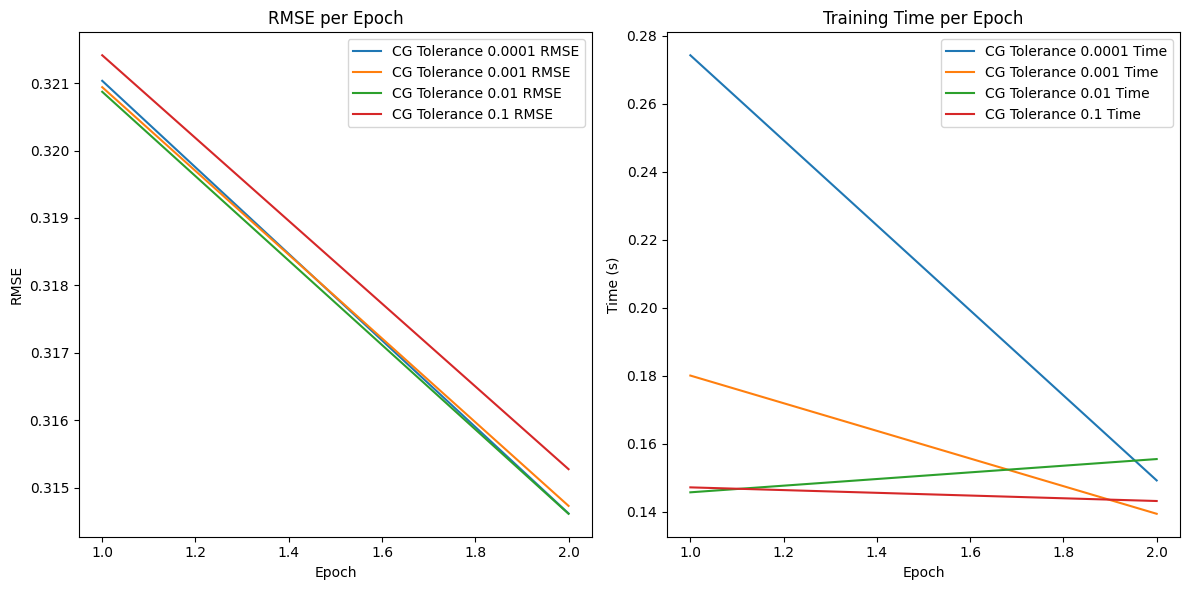

In [15]:
tolerance_values = [1e-4, 1e-3, 1e-2, 1e-1]
plot_results(all_mean_rmse, all_mean_runtimes, all_std_rmse, all_std_runtimes, epochs=epochs, tolerance_values=tolerance_values)